In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres

In [21]:
# Valeurs physiques
gamma = 72e-3; # Tension superficielle eau-air (en N/m)
theta_hydrophobe = 106; # Angle de contact eau-PDMS (en degrés) pré-plasmatisation https://www.sciencedirect.com/science/article/pii/S2590123021000797
theta_hydrophile = 90; # Angle de contact sur les parois mouillées
rho = 1e3; # Masse volumique de l'eau (en kg/m^3)
eta = 1e-3; # Viscosité dynamique de l'eau (en Pa.s)
g = 9.81; # Accélération gravitationnelle (en m/s^2)

# Dimensions géométriques 
h_puce = 2.75e-3; # Épaisseur de la puce (en m)

d_inlet = 2.9e-3; # Diamètre interne de l'inlet (en m)
d_raman = 2e-3; # Diamètre interne du trou Raman (en m)
d_outlet = 1.5e-3 # Diamètre interne de l'outlet (en m)
d_bille = 350e-6; # Diamètre des billes (en m)

L_puits = 700e-6 # Longueur du puits (en m)
W_puits = 700e-6 # Largeur du puits (en m)
h_puits = 630e-6 # Hauteur du puits (en m)

W_canal = 700e-6 # Largeur du canal (en m)
h_canal = 700e-6 # Hauteur du canal (en m)

dist_x = 2e-3 # Longueur en x du serpentin (en m)
dist_y = 6e-3 # Longueur en y du serpentin (en m)

# Volume du système

In [22]:
# Calculs associés
dist_inout = 2* dist_x + 2.5*dist_y + (2*np.pi*W_canal)
dist_puits = dist_x + dist_y + 0.5*(2*np.pi*W_canal)
dist_tot = 2*(dist_inout + dist_puits)
print(f"\nDistance entrée-puits et sortie-puits (L1 et L4): {dist_inout*1000:.2f} mm")
print(f"Distance entre puits (L2 et L3): {dist_puits*1000:.2f} mm")
print(f"Longueur totale du canal : {dist_tot*1000:.2f} mm")

r_inlet = d_inlet / 2
r_raman = d_raman / 2
r_outlet = d_outlet / 2

A_inlet = np.pi * r_inlet**2
A_raman = np.pi * r_raman**2
A_outlet = np.pi * r_outlet**2

# Caclul du volume total
V_puits = L_puits * W_puits * h_puits
V_raman = A_raman * h_puce
V_inlet = A_inlet * h_canal
V_outlet = A_outlet * (h_canal + h_puce)

L_canal = dist_tot - r_inlet - r_outlet

V_canal = W_canal * h_canal * L_canal

V_tot = 3 * V_puits + V_inlet + V_outlet + V_canal + 3 * V_raman
print(f"\nVolume total : {V_tot*1e9:.2f} uL")

L1 = dist_inout;
L2 = dist_puits;
L3 = dist_puits;
L4 = dist_inout;
Vmax = 8.64e-9


Distance entrée-puits et sortie-puits (L1 et L4): 23.40 mm
Distance entre puits (L2 et L3): 10.20 mm
Longueur totale du canal : 67.19 mm

Volume total : 69.41 uL


# V_max selon l'analogie électrique

In [23]:
def calc_R_rect(L, w, h, eta):
    R_rect = (12 * eta * L) / (h**3 * w)
    somme = 1
    for n_i in range(1, 10, 2):
        terme_somme = (192 * h) / (np.pi**5 * n_i**5 * w) * np.tanh(n_i * np.pi * w / (2 * h))
        somme -= terme_somme
    return R_rect / somme

def volume_condensateur(D,e,theta):
    theta_rad = np.deg2rad(theta)
    return np.pi*D**2/4*e + np.pi/3*(1-np.cos(theta_rad))**2*(2+np.cos(theta_rad))*(D/(2*np.sin(theta_rad)))**3

def compute_volumes(L1, L2, L4, V0, t_final=10.0):
    """Renvoie les volumes écoulés dans chaque trou Raman pour un volume injecté V0."""

    V_inlet = volume_condensateur(d_inlet, h_puce, theta_hydrophobe)
    V_raman = volume_condensateur(d_raman, h_puce, theta_hydrophobe)
    V_outlet = volume_condensateur(d_outlet, h_puce, theta_hydrophobe)

    delta_p_inlet = np.abs(rho * g * h_puce + 2 * gamma * np.cos(np.deg2rad(theta_hydrophile)) / (d_inlet / 2))
    delta_p_raman = np.abs(rho * g * h_puce + 2 * gamma * np.cos(np.deg2rad(theta_hydrophile)) / (d_raman / 2))
    delta_p_outlet = np.abs(rho * g * h_puce + 2 * gamma * np.cos(np.deg2rad(theta_hydrophile)) / (d_outlet / 2))

    C0 = V_inlet / delta_p_inlet
    C1 = C2 = C3 = V_raman / delta_p_raman
    C4 = V_outlet / delta_p_outlet

    R1 = calc_R_rect(L1, W_canal, h_canal, eta)
    R2 = calc_R_rect(L2, W_canal, h_canal, eta)
    R3 = R2
    R4 = calc_R_rect(L4, W_canal, h_canal, eta)

    M = -np.diag([-C0, C1, C2, C3, C4])
    g1, g2, g3, g4 = 1/R1, 1/R2, 1/R3, 1/R4

    R_mat = np.array([
        [ g1,       -g1,        0.0,         0.0,     0.0],
        [ g1,  -g1 - g2,       g2,          0.0,      0.0],
        [ 0.0,       g2,    -2.0*g2,       g2,        0.0],
        [ 0.0,       0.0,       g3,   -g3 - g4,        g4],
        [0.0,        0.0,       0.0,      g4,          -g4]
    ])

    A_mat = np.linalg.inv(M) @ R_mat

    v0 = np.array([V0 / C0, 0, 0, 0, 0])
    nt = 1500
    t = np.linspace(0, t_final, nt)

    eigvals, S = np.linalg.eig(A_mat)
    S_inv = np.linalg.inv(S)
    V_t = np.zeros((nt, 5))
    for k, ti in enumerate(t):
        D = np.diag(np.exp(-eigvals * ti))
        V_t[k, :] = (S @ D @ S_inv @ v0).real

    I_t = (R_mat @ V_t.T).T
    i1, i5, i6 = I_t[:, 1], I_t[:, 2], I_t[:, 3]

    V1 = np.trapezoid(i1, t)
    V5 = np.trapezoid(i5, t)
    V6 = np.trapezoid(i6, t)
    return V1, V5, V6, t, i1, i5, i6



--- PARAMÈTRES ---
L1=23.40 mm, L2=10.20 mm, L4=23.40 mm
Vmax autorisé par trou = 8.640 µL

Coefficients k_i (V_i = k_i * V0) :
Trou 1 : k1=0.169,  Trou 2 : k5=0.167,  Trou 3 : k6=0.166

=> Volume injecté maximal V0_max = 51.057 µL

--- VOLUMES ÉCOULÉS POUR V0_max ---
Trou Raman 1 : 8.6400 µL
Trou Raman 2 : 8.5356 µL
Trou Raman 3 : 8.4601 µL


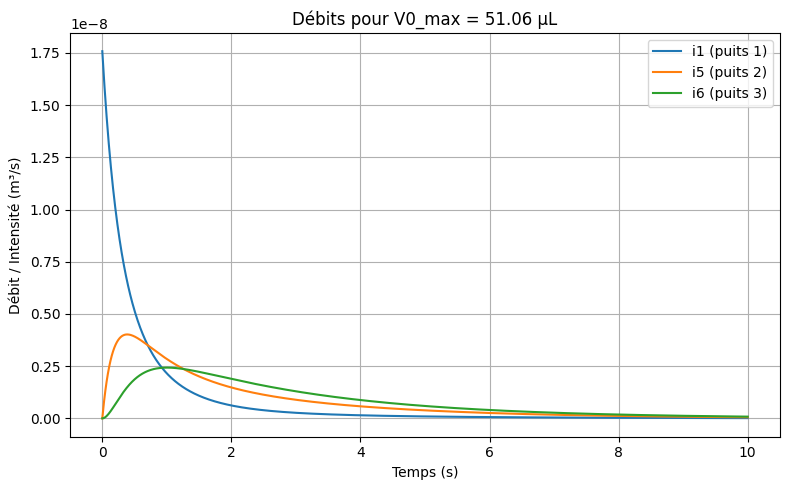

In [24]:
# Calcul du coefficient de proportionnalité
V_test = 100e-9  # 1 µL
V1_test, V5_test, V6_test, t, i1, i5, i6 = compute_volumes(L1, L2, L4, V_test)

# Chaque volume écoulé est proportionnel à V0 → V_i = k_i * V0
k1, k5, k6 = V1_test / V_test, V5_test / V_test, V6_test / V_test
V0_max = min(Vmax / k1, Vmax / k5, Vmax / k6)

# Résultats et tracé
print("\n--- PARAMÈTRES ---")
print(f"L1={L1*1e3:.2f} mm, L2={L2*1e3:.2f} mm, L4={L4*1e3:.2f} mm")
print(f"Vmax autorisé par trou = {Vmax*1e9:.3f} µL")
print(f"\nCoefficients k_i (V_i = k_i * V0) :")
print(f"Trou 1 : k1={k1:.3f},  Trou 2 : k5={k5:.3f},  Trou 3 : k6={k6:.3f}")
print(f"\n=> Volume injecté maximal V0_max = {V0_max*1e9:.3f} µL")

# Vérification : recalcul avec V0_max
V1, V5, V6, t, i1, i5, i6 = compute_volumes(L1, L2, L4, V0_max)

print("\n--- VOLUMES ÉCOULÉS POUR V0_max ---")
print(f"Trou Raman 1 : {V1*1e9:.4f} µL")
print(f"Trou Raman 2 : {V5*1e9:.4f} µL")
print(f"Trou Raman 3 : {V6*1e9:.4f} µL")

# Tracé des débits
plt.figure(figsize=(8,5));
plt.plot(t, i1, label="i1 (puits 1)");
plt.plot(t, i5, label="i5 (puits 2)");
plt.plot(t, i6, label="i6 (puits 3)");
plt.xlabel("Temps (s)");
plt.ylabel("Débit / Intensité (m³/s)");
plt.title(f"Débits pour V0_max = {V0_max*1e9:.2f} µL");
plt.legend();
plt.grid(True);
plt.tight_layout();
plt.show();

# Calcul de l'incertitude sur V0_max 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ======================================================
# === PARAMÈTRES UTILISATEUR : incertitudes à modifier ===
# ======================================================

N_mc = 2000   # Nombre d'itérations Monte-Carlo

# Incertitudes relatives
u_gamma = 0.05
u_rho = 0.01
u_eta = 0.05
u_g = 0.005

u_theta = 10 # incertitude en degrés
u_xy = 27e-6 # incertitude due à l'impression
u_z = 50e-6 # incertitude due à l'impression
u_h_puce = 10e-6

# ======================================================
# === VALEURS NOMINALES ===
# ======================================================

gamma = 72e-3
theta_hydrophobe = 120
rho = 1e3
eta = 1e-3
g = 9.81

h_puce = 2.75e-3
d_inlet = 2.9e-3
d_raman = 2e-3
d_outlet = 1.5e-3
W_canal = 700e-6
h_canal = 700e-6
L1 = dist_inout
L2 = dist_puits
L3 = dist_puits
L4 = dist_inout

Vmax = 8.64e-9   # Volume max par trou Raman

# ======================================================
# === DÉFINITIONS DES FONCTIONS ===
# ======================================================

def calc_R_rect(L, w, h, eta):
    R_rect = (12 * eta * L) / (h**3 * w)
    somme = 1
    for n_i in range(1, 10, 2):
        terme = (192 * h) / (np.pi**5 * n_i**5 * w) * np.tanh(n_i * np.pi * w / (2 * h))
        somme -= terme
    return R_rect / somme

def compute_volumes_uncertainty(L1, L2, L3, L4, V0, gamma, theta, rho, eta, g,
                   h_puce, d_inlet, d_raman, d_outlet,
                   W_canal, h_canal, t_final=10):
    """Renvoie les volumes écoulés dans chaque trou Raman pour un volume injecté V0."""

    V_inlet = np.pi * (d_inlet / 2)**2 * h_puce
    V_raman = np.pi * (d_raman / 2)**2 * h_puce
    V_outlet = np.pi * (d_outlet / 2)**2 * h_puce

    delta_p_inlet = (rho * g * h_puce - 2 * gamma * np.cos(np.deg2rad(theta)) / (d_inlet / 2))
    delta_p_raman = (rho * g * h_puce - 2 * gamma * np.cos(np.deg2rad(theta)) / (d_raman / 2))
    delta_p_outlet = (rho * g * h_puce - 2 * gamma * np.cos(np.deg2rad(theta)) / (d_outlet / 2))

    C0 = V_inlet / delta_p_inlet
    C1 = C2 = C3 = V_raman / delta_p_raman
    C4 = V_outlet / delta_p_outlet

    R1 = calc_R_rect(L1, W_canal, h_canal, eta)
    R2 = calc_R_rect(L2, W_canal, h_canal, eta)
    R3 = calc_R_rect(L3, W_canal, h_canal, eta)
    R4 = calc_R_rect(L4, W_canal, h_canal, eta)

    M = np.diag([-C0, C1, C2, C3, C4])
    g1, g2, g3, g4 = 1/R1, 1/R2, 1/R3, 1/R4

    R_mat = np.array([
        [ g1,       -g1,        0.0,         0.0,     0.0],
        [ g1,  -g1 - g2,       g2,          0.0,      0.0],
        [ 0.0,       g2,    -2.0*g2,       g2,        0.0],
        [ 0.0,       0.0,       g3,   -g3 - g4,        g4],
        [0.0,        0.0,       0.0,      g4,          -g4]
    ])

    A_mat = np.linalg.inv(M) @ R_mat
    v0 = np.array([V0/C0,0,0,0,0])
    nt = 1500
    t = np.linspace(0, t_final, nt)

    eigvals, S = np.linalg.eig(A_mat)
    S_inv = np.linalg.inv(S)
    V_t = np.zeros((nt, 5))
    for k, ti in enumerate(t):
        D = np.diag(np.exp(eigvals * ti))
        V_t[k, :] = (S @ D @ S_inv @ v0)

    I_t = (R_mat @ V_t.T).T
    i0, i1, i5, i6 = I_t[:, 0], I_t[:, 1], I_t[:, 2], I_t[:, 3]

    V1 = np.trapezoid(i1, t)
    V5 = np.trapezoid(i5, t)
    V6 = np.trapezoid(i6, t)
    return V1, V5, V6, t, i0, i1, i5, i6, V_t

def compute_V0_max(L1, L2, L3, L4, gamma, theta, rho, eta, g,
                   h_puce, d_inlet, d_raman, d_outlet,
                   W_canal, h_canal):
    V_test = 100e-9  # 1 µL
    V1_test, V5_test, V6_test, t, i0, i1, i5, i6, v_t = compute_volumes_uncertainty(L1, L2, L3, L4, V_test, gamma, theta, rho, eta, g,
                   h_puce, d_inlet, d_raman, d_outlet,
                   W_canal, h_canal)

    # Chaque volume écoulé est proportionnel à V0 → V_i = k_i * V0
    k1, k5, k6 = V1_test / V_test, V5_test / V_test, V6_test / V_test
    V0_max = min(Vmax / k1, Vmax / k5, Vmax / k6)
    return V0_max

# ======================================================
# === BOUCLE MONTE-CARLO ===
# ======================================================

results = []

for _ in range(N_mc):

    # Tirages aléatoires
    gamma_i = np.random.normal(gamma, gamma*u_gamma)
    theta_i = np.random.normal(theta_hydrophobe, u_theta)
    rho_i = np.random.normal(rho, rho*u_rho)
    eta_i = np.random.normal(eta, eta*u_eta)
    g_i = np.random.normal(g, g*u_g)

    h_puce_i   = np.random.normal(h_puce, u_h_puce)
    d_inlet_i  = np.random.normal(d_inlet, u_xy)
    d_raman_i  = np.random.normal(d_raman, u_xy)
    d_outlet_i = np.random.normal(d_outlet, u_xy)
    W_canal_i  = np.random.normal(W_canal, u_xy)
    h_canal_i  = np.random.normal(h_canal, u_z)
    L1_i = np.random.normal(L1, u_xy)
    L2_i = np.random.normal(L2, u_xy)
    L3_i = np.random.normal(L3, u_xy)
    L4_i = np.random.normal(L4, u_xy)

    # Calcul Monte-Carlo
    V0_i = compute_V0_max(L1_i, L2_i, L3_i, L4_i, gamma_i, theta_i, rho_i, eta_i, g_i,
                          h_puce_i, d_inlet_i, d_raman_i, d_outlet_i,
                          W_canal_i, h_canal_i)

    results.append(V0_i)

results = np.array(results)

# ======================================================
# === ANALYSE ET AFFICHAGE ===
# ======================================================

mean = np.mean(results)
std = np.std(results)
p_low, p_high = np.percentile(results, [2.5, 97.5])

print("\n====================")
print("  INCERTITUDE SUR V0_max")
print("====================")
print(f"Moyenne : {mean*1e9:.3f} µL")
print(f"Écart-type : {std*1e9:.3f} µL")
print(f"Intervalle 95% : [{p_low*1e9:.3f}, {p_high*1e9:.3f}] µL")

plt.hist(results*1e9, bins=40, alpha=0.7)
plt.xlabel("V0_max (µL)")
plt.ylabel("Occurrences")
plt.title("Distribution Monte-Carlo de V0_max")
plt.grid(True)
plt.show()


# Délai entre les changements de milieu

Voici les données nécessaires pour ce problème:

In [25]:
c_0 = 11 # Concentration initiale de glucose (mol/m^3) (Valeur typique tirée du mémoire de Nassim)
D_gluc = 6.7e-10 # Diffusivité typique du glucose dans l'eau (m^2/s) https://pubmed.ncbi.nlm.nih.gov/23224430/
q_gluc = 3.9e-17 # Consommation de glucose par cellule (mol/cell*s) (Valeur typique tirée du mémoire de Nassim)
rho = 2.8e14 # Densité cellulaire (cell/m^3) (Valeur typique tirée du mémoire de Nassim)

K_M = 0.04 # Constante de michaelis-menten du glucose (mol/m^3) (Valeur typique tirée du mémoire de Nassim)

Le mémoire de Nassim propose une relation linéaire entre le temps avant que la concentration du milieu en glucose atteigne la constante de Michaelis-Menten ($K_M$) et le ratio volume du milieu accessible ($V_m$) / volume des tissus ($V_t$). Toutefois, cette relation ne peut être utilisée que si le nombre de Damkölher est inférieur à 1 (régime où la diffusion domine). Il est possible de le vérifier en s'assurant que la plus grande distance de diffusion possible est inférieur au seuil donné par l'équation (7) de l'article de Nassim (P.68):

$$
L < L_{max} = \sqrt{ 8 \frac{c_0 D_M}{q_{max} \rho_{cell}} \frac{V_M}{V_T} }
$$

In [26]:
# Volumes définissant le ratio Vm/Vt
V_M = 3*V_puits + V_canal # Volume du milieu disponible (canal + puits)
V_T = 3* 4/3 * np.pi * (d_bille/2)**3 # Volume des tissus (les 3 billes)

# La plus longue distance possible de diffusion correspond à la distance inlet-puits 1, puis à la descente dans le puits
L_diff = h_puits + h_canal + dist_inout
L_max = np.sqrt(c_0 / (q_gluc * rho) * V_M/V_T * 8*D_gluc) # équation (7)
if L_diff < L_max:
    print(f"La longueur de diffusion ({L_diff:.4f} m) est inférieure à la longueur maximale ({L_max:.4f} m) pour que Da < 1.")
    print(f"Il est possible d'utiliser la fonction de Nassim")
else :
    print(f"La longueur de diffusion ({L_diff:.4f} m) est supérieure à la longueur maximale ({L_max:.4f} m) pour que Da < 1.")
    print(f"Il n'est pas possible d'utiliser la fonction de Nassim")

La longueur de diffusion (0.0247 m) est inférieure à la longueur maximale (0.0513 m) pour que Da < 1.
Il est possible d'utiliser la fonction de Nassim


En calculant le nombre de Damkhöler, nous devrions obtenir $Da < 1$ :

In [27]:
# Expressions tirées de la page 68 du mémoire de Nassim, entre les équations (6) et (7)
tau_diff = L_diff**2 / (8 * D_gluc)
tau_reac = c_0 / (q_gluc * rho) * V_M/V_T
Da = tau_diff / tau_reac

print(f"\nNombre de Damköhler : Da = {Da:.2f}")
print(f"La réaction est donc beaucoup plus {'rapide' if Da > 1 else 'lente'} que la diffusion.")
print(f"C'est donc la {'diffusion' if Da < 1 else 'réaction'} qui détermine l'apport en glucose aux cellules.")
print(f"Ainsi, on peut considérer que le profil de concentration de glucose est {'quasi-uniforme' if Da < 1 else 'variable'}.")


Nombre de Damköhler : Da = 0.23
La réaction est donc beaucoup plus lente que la diffusion.
C'est donc la diffusion qui détermine l'apport en glucose aux cellules.
Ainsi, on peut considérer que le profil de concentration de glucose est quasi-uniforme.


Ainsi, il est possible de trouver le temps nécessaire pour que la concentration du milieu en glucose atteigne la constante de Michaelis-Menten à l'aide de la relation suivante :

$$
t [h] \approx 0.25 \left( \frac{V_m}{V_t} \right)
$$

Figure 4-4C de l'article de Nassim :

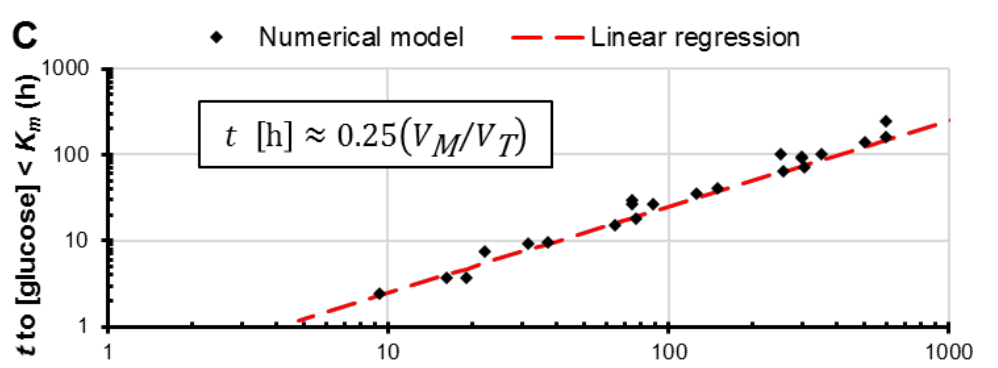

In [28]:
ratio = V_M / V_T
t_M =  0.25 * ratio

print(f"Ratio V_m/V_t: {ratio:.1f}")
print(f"Temps avant d'atteinte K_M : {t_M:.2f} heures")

Ratio V_m/V_t: 486.6
Temps avant d'atteinte K_M : 121.66 heures


Étant donné que nous définissons le temps entre les changement de milieu comme étant le temps nécessaire pour atteindre 10% de la valeur initiale de la concentration, la valeur obtenue précédemment n'est pas réaliste ($K_M = 0.04 << 1.1 = 0.1c_0$).

Il est donc nécessaire d'estimer l'évolution de la concentration dans le temps. Pour ce faire, il est possible d'approximer notre situation comme étant unidimensionnelle (1D), où la sphère de tissus se trouve sous une colonne d'eau. (Conditions sem.4 notes de cours, slide 40), ce qui nous amène à l'équation suivante :

$$
D \frac{\partial^2 C}{\partial y^2} = \frac{\partial C}{\partial t}
$$

Suite à la résolution et à l'application des conditions aux frontières (voir notes de cours sem.4), la première approximation de l'expression de la concentration moyenne suit une exponentielle négative :

$$
\left< C \right> (t) \approx C_0 e^{-k t}
$$

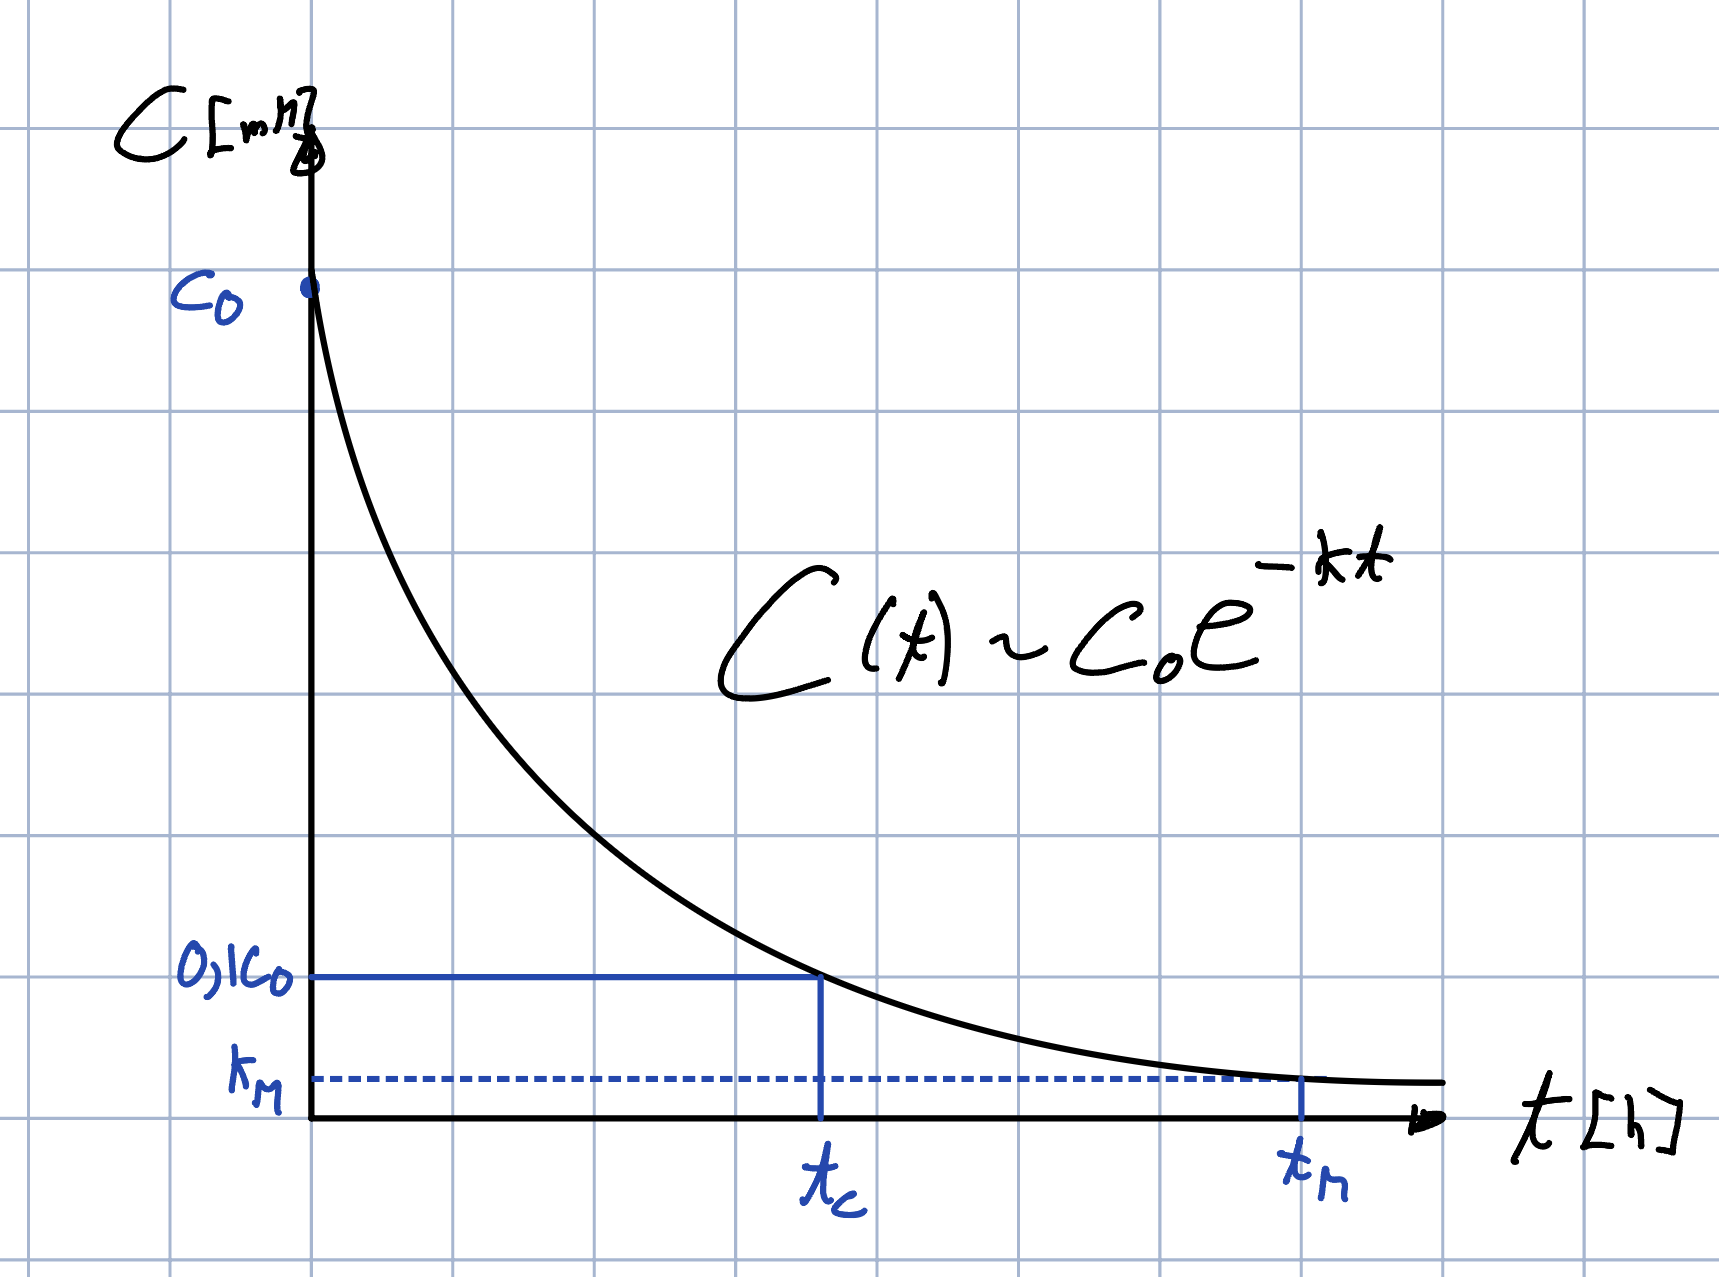

Étant donné que le point $(t_M, K_M)$ est déjà connu, il est alors possible de déterminer la valeur de la constante $k$ avec :

$$
k=\frac{-\ln \left( {\frac{K_M}{C_0}} \right)}{t_M}
$$

Le temps entre chaque changement de milieu ($t_c$) peut alors être trouvé avec :

$$
t=\frac{-\ln \left( 0.1 \right)}{k}
$$

In [29]:
cst = -np.log(K_M / c_0) / t_M
t_c = -np.log(0.1) / cst

print(f"\nTemps entre chaque changement de milieu : {t_c:.2f} heures")


Temps entre chaque changement de milieu : 49.87 heures


# Niveau d'hypoxie des sphéroïdes

Puisque l'oxygène diffuse davantage dans le PDMS que dans l'eau, pour modéliser le pire scénario, on considère une bille entourée d'un milieu infini d'eau, tel qu'illustré ci-dessous :

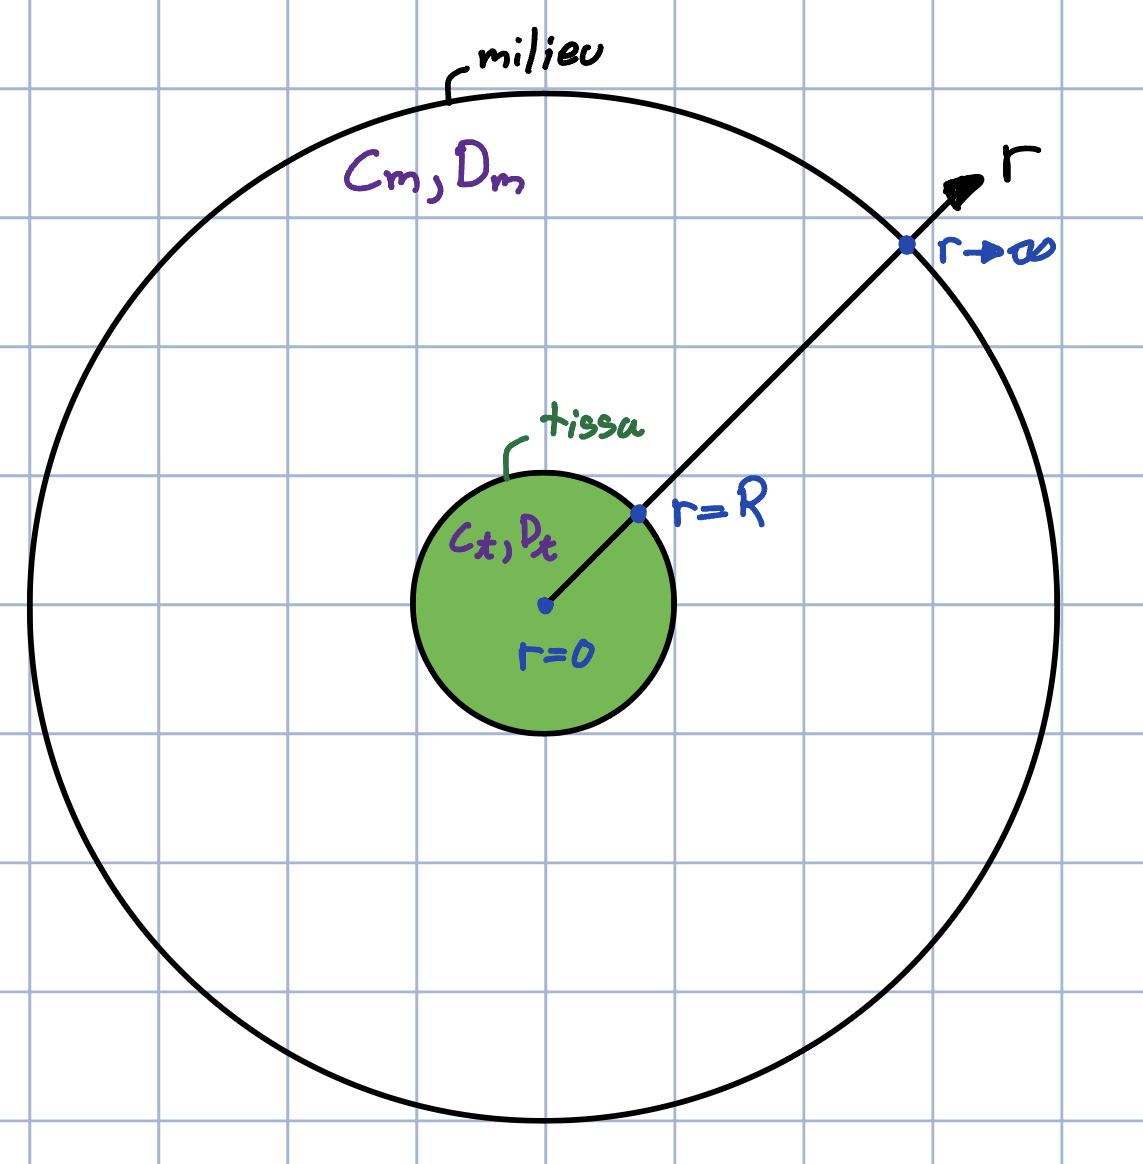

Les numéros encerclés correspondent aux conditions aux frontières :

1 - La concentration au centre du tissu est constante (Condition de Neumann) :
$$ C_t'(r=0)=0 $$

2 - La concentration à la surface ($ C_s $) est la même dans le tissu et le milieu (Conditions de Dirichlet) :
$$ C_t(r=R)=C_m(r=R)=C_s $$
(L'équation de continuité est la suivante)
$$ -D_m \frac{\partial C_m}{\partial r}|_{r=R} = -D_t \frac{\partial C_t}{\partial r}|_{r=R} $$

3 - La concentration à l'infini ($ C_{\infty} $) est définie par une condition de Dirichlet :
$$ C_t(r \rightarrow \infty)=C_{\infty} $$

Voici les valeurs considérées pour ce problème :

In [30]:
c_m = c_inf = 0.21 # Concentration d'oxygène dans le milieu (mol/m^3) (Valeur typique tirée du mémoire de Nassim)
c_t = 1.02 # Concentration d'oxygène dans le tissu (mol/m^3) (Valeur typique tirée du mémoire de Nassim)
c_hypoxie = 0.0126 # Concentration d'oxygène critique où le tissu devient hypoxique (mol/m^3) (Valeur tirée de la thèse à Elena)

D_m = 2.44e-9 # Diffusivité de l'oxygène dans le milieu (m^2/s) (Valeur typique tirée du mémoire de Nassim)
D_t = 1.85e-9 # Diffusivité de l'oxygène dans le tissu (m^2/s) (Valeur typique tirée du mémoire de Nassim)

q_O2 = 7.4e-17 # Consommation d'oxygène par cellule (mol/cell*s) (Valeur typique tirée du mémoire de Nassim)

R = d_bille/2 # Rayon de la sphère de cellules cancéreuses (m)

Partons de l'équation de convection/diffusion/réaction :

$$ \frac{\partial C}{\partial t} = D \nabla^2 C - \vec{v} \cdot \nabla C + \mathcal{R} $$

Étant donné qu'il n'y a pas de convection dans le milieu (qui est immobile), le nombre de Péclet est nul ($Pe=0$) :

$$ \frac{\partial C}{\partial t} = D \nabla^2 C + \mathcal{R} $$

Maintenant, déterminons si c'est la diffusion où la réaction qui est dominante dans cette situation. Pour cela, calculons de nombre de Damkölher:

In [31]:
tau_diff = (d_bille/2)**2 / D_t
tau_reac = c_t / (q_O2 * rho)
Da = tau_diff / tau_reac
print(f"\nNombre de Damköhler du tissu: Da = {Da:.2f}")
print(f"La réaction est donc beaucoup plus {'rapide' if Da > 1 else 'lente'} que la diffusion.")
print(f"C'est donc la {'diffusion' if Da < 1 else 'réaction'} qui détermine l'apport en glucose aux cellules.")


Nombre de Damköhler du tissu: Da = 0.34
La réaction est donc beaucoup plus lente que la diffusion.
C'est donc la diffusion qui détermine l'apport en glucose aux cellules.


On peut donc considérer que le terme de réaction ($\mathcal{R}$) dans le tissu est une constante correspondant au taux de consommation des cellules, alors que dans le milieu, il n'y a pas de réaction :

$$ \mathcal{R_t} = - \rho q $$
$$ \mathcal{R_m} = 0 $$

Combiné au fait que le système peut être considéré en une seul dimension (radiale), on obtient les équtions suivantes :

$$
\frac{\partial C_t}{\partial t} = D \left( \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial C_t}{\partial r} \right) \right) - \rho q
$$

$$
\frac{\partial C_m}{\partial t} = D \left( \frac{1}{r^2} \frac{\partial}{\partial r} \left( r^2 \frac{\partial C_m}{\partial r} \right) \right)
$$

Puisque le PDMS est très perméable à l'oxygène, on peut considérer que le volume du milieu de culutre est infini, donc que le système est en régime permanent ($\frac{\partial C_t}{\partial t} = \frac{\partial C_m}{\partial t} = 0 $) :

$$
\frac{\partial}{\partial r} \left( r^2 \frac{\partial C_t}{\partial r} \right) = \frac{\rho q r^2}{D_t}
$$

$$
\frac{\partial}{\partial r} \left( r^2 \frac{\partial C_m}{\partial r} \right) = 0
$$

En intégrant à deux reprises selon r :

$$
C_t(r)=\frac{\rho q r^2}{6D_t} - \frac{A_t}{r} + B_t
$$

$$
C_m(r) = - \frac{A_m}{r} + B_m
$$

Où $A_i$ et $B_i$ sont des constantes d'intégration. En considérant les conditions aux frontières énoncées plus haut:

$$
C_t(r)=C_s + \frac{\rho q}{6D_t} \left( r^2 - R^2 \right)
$$

$$
C_m(r) = C_{\infty} - \left( C_{\infty} - C_s \right) \frac{R}{r}
$$

En considérant l'équation de continuité, on obtient le profil de concentration au sein du tissu :

$$
C_t(r)= C_{\infty} + \frac{\rho q}{3} \left( \frac{r^2}{2D_t} - \left( \frac{1}{D_m} + \frac{1}{2D_t} \right) R^2 \right)
$$

In [32]:
# Équation de la concentration en oxygène dans le tissu en fonction du rayon
def get_tissue_02_concentration(rayon):
    return c_inf + q_O2 * rho / 3 * (rayon**2 / (2 * D_t) - (1/D_m + 1/(2*D_t)) * R**2)

Il est alors possible de vérifier si le tissu est en hypoxie. Si la concentration en oxygène au centre du sphéroïde (le minimum global) est supérieure à la concentration où les cellules sont en hypoxie, alors le sphéroïde n'est pas en hypoxie :

In [33]:
c_centre = get_tissue_02_concentration(0)
print(f"Concentration en O2 au centre du sphéroïde : {c_centre:.5f} mM")

if c_centre > c_hypoxie :
    print(f"Il n'y a pas d'hypoxie! Le taux d'hypoxie est donc de 0%.")
else :
    # Le taux d'hypoxie pourrait être calculé à partir du rayon où le seuil critique est atteint, puis calculer
    # Le pourcentage du volume en hypoxie par rapport au volume total du spéhoïde
    pass

Concentration en O2 au centre du sphéroïde : 0.06615 mM
Il n'y a pas d'hypoxie! Le taux d'hypoxie est donc de 0%.
